In [1]:
import os
from glob import glob

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

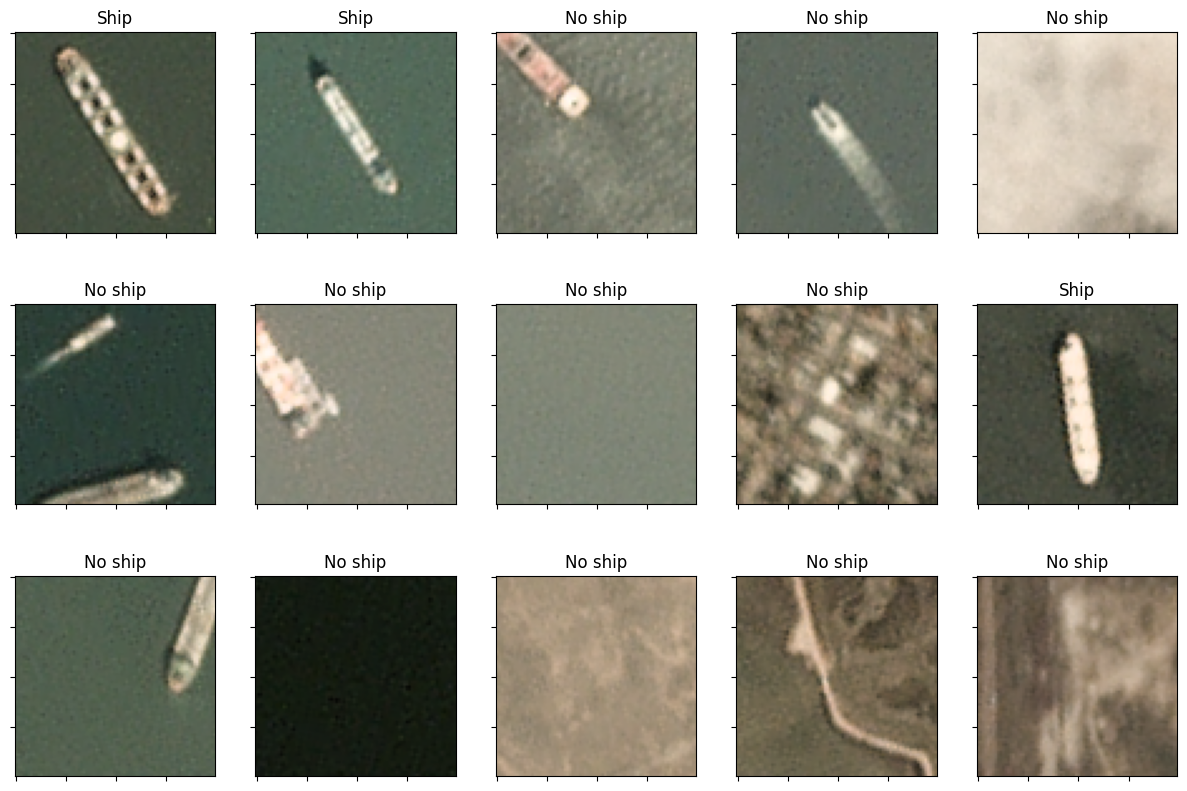

In [2]:
# Set basepath
basepath = ".\shipsnet\shipsnet"

# Generate a list of files for ship and no_ship files
files_list_no_ship = glob(os.path.join(basepath, "0_*"))
files_list_ship = glob(os.path.join(basepath, "1_*"))

# Open the files
images = []
labels = []
text_labels = ['No ship', 'Ship']

for file in files_list_no_ship:
    img_path = os.path.join(file)
    img = cv2.imread(img_path)
    if img is not None:  # Check if the image was loaded successfully
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(0)
    else:
        print(f"Image not found or unreadable: {img_path}")

for file in files_list_ship:
    img_path = os.path.join(file)
    img = cv2.imread(img_path)
    if img is not None:  # Check if the image was loaded successfully
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(1)
    else:
        print(f"Image not found or unreadable: {img_path}")
    
images = np.array(images, dtype=np.int64)
labels = np.array(labels, dtype=np.int64)

# Split the data into train (70%), validation (20%) and test (10%) datasets
np.random.seed(27)
np.random.shuffle(images)

np.random.seed(27)
np.random.shuffle(labels)

train = int(0.7*len(images))
validation = int(0.2*len(images))
test = int(0.1*len(images))

X_train, y_train = images[:train], labels[:train]
X_validation, y_validation = images[train:(validation+train)], labels[train:(validation+train)]
X_test, y_test = images[(validation+train):], labels[(validation+train):]

n_classes = 2

# Change the labels from categorical to one-hot encoding, i.e., class '1' transforms into vector [0, 1]
y_train = to_categorical(y_train, n_classes)
y_validation = to_categorical(y_validation, n_classes)
y_test = to_categorical(y_test, n_classes)

# Plot some sample images
n_rows = 3
n_cols = 5

plt.figure(figsize=(15, 10))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    index = random.randint(0, len(X_train) - 1)
    plt.imshow(X_train[index])
    plt.title(text_labels[np.argmax(y_train[index])])

In [3]:
# Define the Neural Network
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='linear', input_shape = (80, 80, 3), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 40, 40, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 40, 40, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)       

In [4]:
# Compile and fit the NN 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("ship_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, epochs=40, verbose=1, validation_data=(X_validation, y_validation), callbacks=[checkpoint])

# Sauvegarder le modèle au format HDF5
model.save("ship_detection_model.h5")


Epoch 1/40


174/175 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8563
Epoch 1: val_accuracy improved from -inf to 0.96500, saving model to ship_detection.keras
175/175 [==============================] - 10s 49ms/step - loss: 0.3985 - accuracy: 0.8568 - val_loss: 0.1606 - val_accuracy: 0.9650
Epoch 2/40
174/175 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9228
Epoch 2: val_accuracy improved from 0.96500 to 0.97375, saving model to ship_detection.keras
175/175 [==============================] - 8s 44ms/step - loss: 0.2245 - accuracy: 0.9232 - val_loss: 0.0976 - val_accuracy: 0.9737
Epoch 3/40
175/175 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9471
Epoch 3: val_accuracy did not improve from 0.97375
175/175 [==============================] - 7s 42ms/step - loss: 0.1529 - accuracy: 0.9471 - val_loss: 0.1794 - val_accuracy: 0.9250
Epoch 4/40
175/175 [==============================] - ETA: 0s - loss: 0.1090 -

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

13/13 [==============================] - 0s 16ms/step - loss: 0.0356 - accuracy: 0.9900
Test Loss: 0.03564716875553131
Test Accuracy: 0.9900000095367432


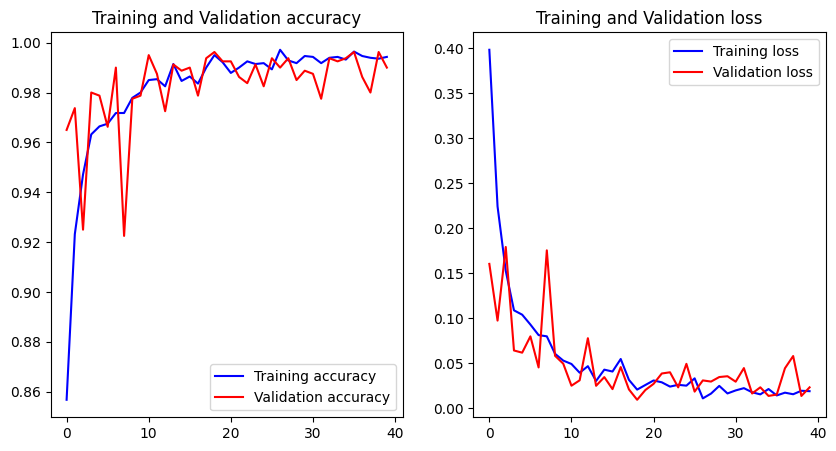

In [6]:
# Show accuracy and loss plots of the model 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [7]:
# Obtain predictions
predicted_class = model.predict(X_test)

predicted_class_probability = np.max(predicted_class, axis=1)*100
predicted_class = np.argmax(predicted_class, axis=1)
true_class = np.argmax(y_test, axis=1)

correct = []
incorrect = []

for i in range(len(predicted_class)):
    if predicted_class[i] == true_class[i]:
        correct.append(i)
    else:
        incorrect.append(i)

print('Correct predictions: ', len(correct))        
print('Incorrect predictions: ', len(incorrect)) 

13/13 [==============================] - 0s 16ms/step
Correct predictions:  396
Incorrect predictions:  4


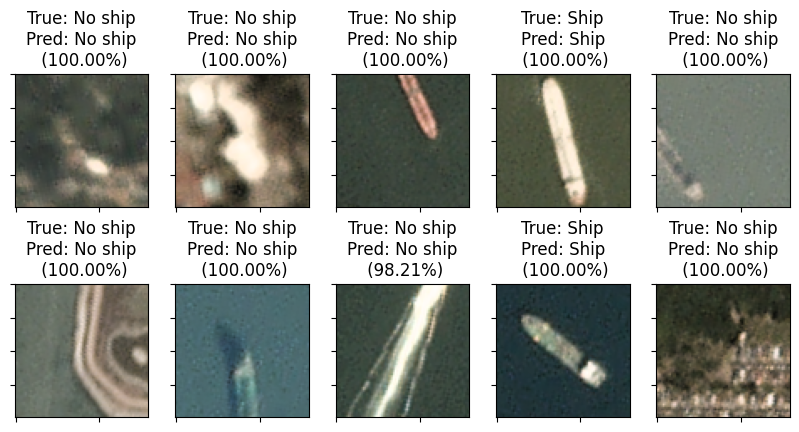

In [8]:
random.shuffle(correct)
random.shuffle(incorrect)

# Show some CORRECT PREDICTIONS
n_rows = 2
n_cols = 5

plt.figure(figsize=(10, 5))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[correct[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[correct[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[correct[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[correct[i]])

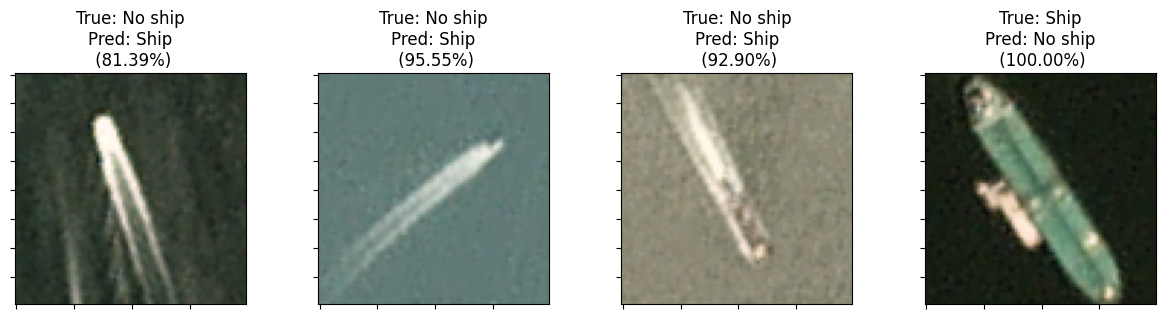

In [9]:
# Show the INCORRECT PREDICTIONS
n_rows = 1
n_cols = len(incorrect)

plt.figure(figsize=(15, 3*n_rows))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[incorrect[i]], cmap=plt.get_cmap('gray'))
    plt.title('True: ' + str(text_labels[true_class[incorrect[i]]]) + 
              '\nPred: ' + str(text_labels[predicted_class[incorrect[i]]]) +
              '\n' + " (%.2f%%)" % predicted_class_probability[incorrect[i]])

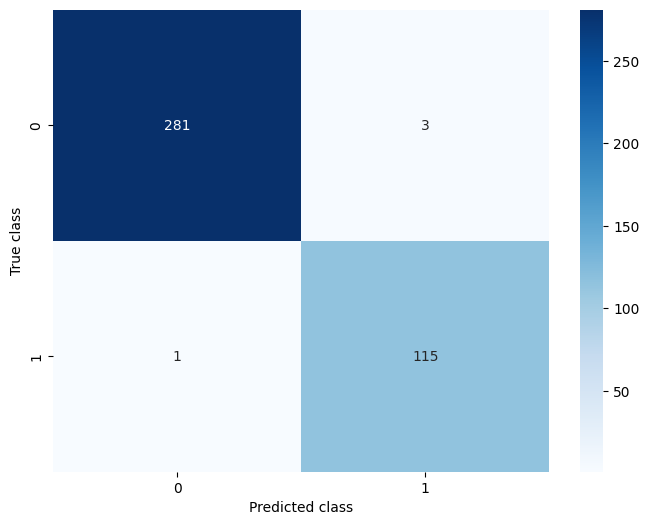

In [10]:
# Show confussion Matrix
cm = confusion_matrix(true_class, predicted_class)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

Scene file: ['.\\shipsnet\\scenes\\sfbay_1.png']
Step 0 of 84
Step 1 of 84
Step 2 of 84
Step 3 of 84
Step 4 of 84
Step 5 of 84
Step 6 of 84
Step 7 of 84
Step 8 of 84
Step 9 of 84
Step 10 of 84
Step 11 of 84
Step 12 of 84
Step 13 of 84
Step 14 of 84
Step 15 of 84
Step 16 of 84
Step 17 of 84
Step 18 of 84
Step 19 of 84
Step 20 of 84
Step 21 of 84
Step 22 of 84
Step 23 of 84
Step 24 of 84
Step 25 of 84
Step 26 of 84
Step 27 of 84
Step 28 of 84
Step 29 of 84
Step 30 of 84
Step 31 of 84
Step 32 of 84
Step 33 of 84
Step 34 of 84
Step 35 of 84
Step 36 of 84
Step 37 of 84
Step 38 of 84
Step 39 of 84
Step 40 of 84
Step 41 of 84
Step 42 of 84
Step 43 of 84
Step 44 of 84
Step 45 of 84
Step 46 of 84
Step 47 of 84
Step 48 of 84
Step 49 of 84
Step 50 of 84
Step 51 of 84
Step 52 of 84
Step 53 of 84
Step 54 of 84
Step 55 of 84
Step 56 of 84
Step 57 of 84
Step 58 of 84
Step 59 of 84
Step 60 of 84
Step 61 of 84
Step 62 of 84
Step 63 of 84
Step 64 of 84
Step 65 of 84
Step 66 of 84
Step 67 of 84
Step 68 o

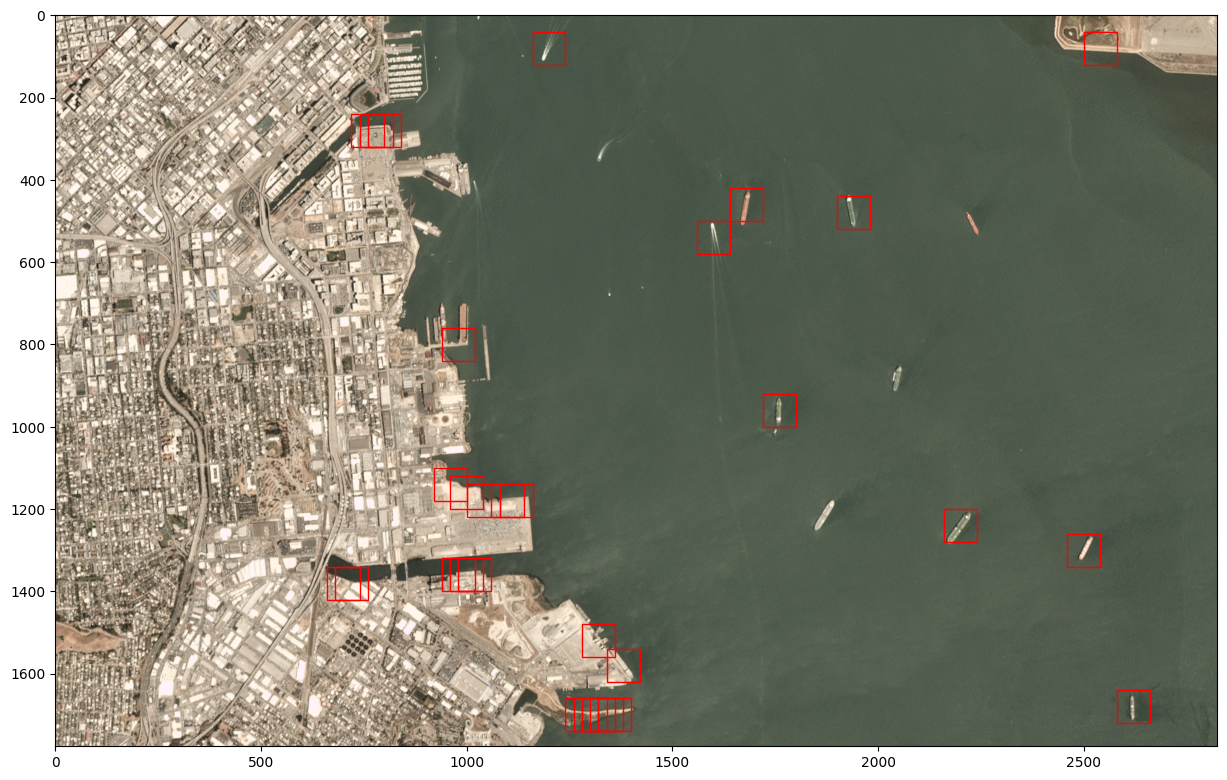

In [11]:
# Load and show scene
basepath = ".\shipsnet\scenes"
stride = 20

scene_list = glob(os.path.join(basepath, "sfbay_1*"))
print("Scene file:", scene_list)

scene_file = scene_list[0]
img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)

# Obtain predictions in 80x80 boxes inside scene
for h in range(0, height-80, stride):
    print("Step", int(h/stride), "of", int((height-80)/stride))
    
    for w in range(0, width-80, stride):  
        img_box = []
        img_box.append(img[h:h+80, w:w+80])
        img_box = np.array(img_box, dtype=np.int64)
        
        prediction = model.predict(img_box, verbose=False)
        prediction_probability = np.max(prediction)
        prediction_class = np.argmax(prediction)
        
        if (prediction_class == 1 and prediction_probability > 0.95):
            ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor='r', facecolor='none'))
            
plt.show()